In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.inspection import permutation_importance 
import matplotlib.pyplot as plt 
import seaborn as sns 
import shap 
from lime.lime_tabular import LimeTabularExplainer
import warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
import geopandas as gpd

gdf = gpd.read_file("output.geojson")
df=gdf.copy()
df.head(5)

,S/N,station_name_geo,Address,Latitude,Longitude,State,distance_to_nearest_road_m,distance_to_nearest_road_km,roads_within_1000m,road_length_within_1000m,...,road_density_3000m,roads_within_5000m,road_length_within_5000m,road_density_5000m,lga_population,station_name_cleaned,station_name_csv,sales_volume,date,geometry
0,1,Yola,"Km 5, Yola-Numan Road, Jimeta, Adamawa State",9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,...,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,Yola,Yola (109),0.0,2015-01-02,POINT (12.19643 9.35923)
1,1,Yola,"Km 5, Yola-Numan Road, Jimeta, Adamawa State",9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,...,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,Yola,Yola (109),0.0,2015-01-03,POINT (12.19643 9.35923)
2,1,Yola,"Km 5, Yola-Numan Road, Jimeta, Adamawa State",9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,...,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,Yola,Yola (109),0.0,2015-01-05,POINT (12.19643 9.35923)
3,1,Yola,"Km 5, Yola-Numan Road, Jimeta, Adamawa State",9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,...,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,Yola,Yola (109),0.0,2015-01-06,POINT (12.19643 9.35923)
4,1,Yola,"Km 5, Yola-Numan Road, Jimeta, Adamawa State",9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,...,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,Yola,Yola (109),0.0,2015-01-07,POINT (12.19643 9.35923)


In [4]:
# Drop Non-ML Columns 
df = df.drop(columns=[ 
"S/N", 
"station_name_cleaned", 
"station_name_csv", 
"Address", 
"geometry",
"date",
# "distance_to_nearest_road_m",
# "distance_to_nearest_road_km"
], errors="ignore")

In [5]:
# # Handle Date (explicit & simple) 
# df["date"] = pd.to_datetime(df["date"], errors="coerce") 
# df["year"] = df["date"].dt.year 
# df["month"] = df["date"].dt.month 
# df["day"] = df["date"].dt.day 
# df["dayofweek"] = df["date"].dt.dayofweek 
# df = df.drop(columns=["date"])

In [6]:
df.isna().sum()

station_name_geo                    0
Latitude                            0
Longitude                           0
State                               0
distance_to_nearest_road_m     119064
distance_to_nearest_road_km    119064
roads_within_1000m                  0
road_length_within_1000m            0
road_density_1000m                  0
roads_within_3000m                  0
road_length_within_3000m            0
road_density_3000m                  0
roads_within_5000m                  0
road_length_within_5000m            0
road_density_5000m                  0
lga_population                 104544
sales_volume                       78
dtype: int64

In [7]:
# df.dropna(subset=['distance_to_nearest_road_m','distance_to_nearest_road_km','lga_population','sales_volume']).reset_index(drop=True)
df.dropna().reset_index(drop=True)
df.isna().sum()

station_name_geo                    0
Latitude                            0
Longitude                           0
State                               0
distance_to_nearest_road_m     119064
distance_to_nearest_road_km    119064
roads_within_1000m                  0
road_length_within_1000m            0
road_density_1000m                  0
roads_within_3000m                  0
road_length_within_3000m            0
road_density_3000m                  0
roads_within_5000m                  0
road_length_within_5000m            0
road_density_5000m                  0
lga_population                 104544
sales_volume                       78
dtype: int64

In [8]:
# Assuming df is your DataFrame (without geometry column)
print(f"Original shape: {df.shape}")

# Step 1: Convert all empty strings to NaN
df_clean = df.replace('', np.nan)

# Step 2: Also convert other common null representations
null_patterns = ['null', 'NULL', 'None', 'none', 'NA', 'na', 'N/A', 'n/a', 'missing', 'Missing']
df_clean = df_clean.replace(null_patterns, np.nan)

# Step 3: Drop rows with ANY NaN values
df_clean = df_clean.dropna()

print(f"Cleaned shape: {df_clean.shape}")
print(f"Dropped {len(df) - len(df_clean)} rows")
print(f"Kept {len(df_clean)} rows ({100*len(df_clean)/len(df):.1f}%)")

Original shape: (418176, 17)


Cleaned shape: (220659, 17)
Dropped 197517 rows
Kept 220659 rows (52.8%)


In [9]:
# =============== SAVE AS GEOJSON ===============

# Create Point geometries from your coordinates
# Replace 'latitude' and 'longitude' with your actual column names
from shapely.geometry import Point
geometry = [Point(lon, lat) for lon, lat in zip(df_clean['Longitude'], df_clean['Latitude'])]

# Create GeoDataFrame with WGS84 coordinate system (required for GeoJSON)
gdf_clean = gpd.GeoDataFrame(
    df_clean, 
    geometry=geometry,
    crs="EPSG:4326"  # WGS84
)

# Save as GeoJSON
output_file = "final_output.geojson"
gdf_clean.to_file(output_file, driver="GeoJSON")

print(f"✅ Saved as GeoJSON: '{output_file}'")
print(f"   Total features: {len(gdf_clean)}")
print(f"   CRS: {gdf_clean.crs}")

✅ Saved as GeoJSON: 'final_output.geojson'
   Total features: 220659
   CRS: EPSG:4326


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.inspection import permutation_importance 
import matplotlib.pyplot as plt 
import seaborn as sns 
import shap 
from lime.lime_tabular import LimeTabularExplainer
import warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
import geopandas as gpd

gdf = gpd.read_file("final_output.geojson")
df_clean=gdf.copy()
df_clean.head(5)

,station_name_geo,Latitude,Longitude,State,distance_to_nearest_road_m,distance_to_nearest_road_km,roads_within_1000m,road_length_within_1000m,road_density_1000m,roads_within_3000m,road_length_within_3000m,road_density_3000m,roads_within_5000m,road_length_within_5000m,road_density_5000m,lga_population,sales_volume,geometry
0,Yola,9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,1.741464e+06,5470970,1.369558e+09,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,0.0,POINT (12.19643 9.35923)
1,Yola,9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,1.741464e+06,5470970,1.369558e+09,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,0.0,POINT (12.19643 9.35923)
2,Yola,9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,1.741464e+06,5470970,1.369558e+09,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,0.0,POINT (12.19643 9.35923)
3,Yola,9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,1.741464e+06,5470970,1.369558e+09,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,0.0,POINT (12.19643 9.35923)
4,Yola,9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,1.741464e+06,5470970,1.369558e+09,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,0.0,POINT (12.19643 9.35923)


In [3]:
# Target & Features 
y = df_clean["sales_volume"] 
X = df_clean.drop(columns=["sales_volume","geometry"])

In [4]:
# Separate Numeric & Categorical 
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns 
categorical_cols = X.select_dtypes(include=["object"]).columns 
print("Numeric:", list(numeric_cols)) 
print("Categorical:", list(categorical_cols)) 

Numeric: ['Latitude', 'Longitude', 'distance_to_nearest_road_m', 'distance_to_nearest_road_km', 'roads_within_1000m', 'road_length_within_1000m', 'road_density_1000m', 'roads_within_3000m', 'road_length_within_3000m', 'road_density_3000m', 'roads_within_5000m', 'road_length_within_5000m', 'road_density_5000m', 'lga_population']
Categorical: ['station_name_geo', 'State']


In [5]:
# Encode Categorical Variables (NO pipeline) 
 
ohe = OneHotEncoder( 
    handle_unknown="ignore", 
    sparse=False 
) 
 
X_cat = ohe.fit_transform(X[categorical_cols]) 
cat_feature_names = ohe.get_feature_names_out(categorical_cols) 
 
X_cat_df = pd.DataFrame( 
    X_cat, 
    columns=cat_feature_names, 
    index=X.index 
) 

In [7]:
# Scale Numeric Features 
 
scaler = StandardScaler() 
 
X_num_scaled = scaler.fit_transform(X[numeric_cols]) 
 
X_num_df = pd.DataFrame( 
    X_num_scaled, 
    columns=numeric_cols, 
    index=X.index 
) 

In [8]:
# Combine Features (Fully Explicit) 
 
X_final = pd.concat([X_num_df, X_cat_df], axis=1) 
 
print(X_final.shape)

(220659, 105)


In [9]:
#Train / Test Split 
X_train, X_test, y_train, y_test = train_test_split( 
X_final, 
y, 
test_size=0.2, 
random_state=42 
) 

In [10]:
df_clean.isna().sum()

station_name_geo               0
Latitude                       0
Longitude                      0
State                          0
distance_to_nearest_road_m     0
distance_to_nearest_road_km    0
roads_within_1000m             0
road_length_within_1000m       0
road_density_1000m             0
roads_within_3000m             0
road_length_within_3000m       0
road_density_3000m             0
roads_within_5000m             0
road_length_within_5000m       0
road_density_5000m             0
lga_population                 0
sales_volume                   0
geometry                       0
dtype: int64

In [ ]:
# #Linear Regression 
# lin_reg = LinearRegression() 
# lin_reg.fit(X_train, y_train) 
# y_pred_lr = lin_reg.predict(X_test) 

# #Metrics 
# print("Linear Regression") 
# print("R2:", r2_score(y_test, y_pred_lr)) 
# print("MAE:", mean_absolute_error(y_test, y_pred_lr)) 
# print("RMSE:", mean_squared_error(y_test, y_pred_lr))
#  Linear Regression
# R2: 0.22589912636035514
# MAE: 4544.090800043053
# RMSE: 38138592.00903442

Linear Regression
R2: 0.22589912636035514
MAE: 4544.090800043053
RMSE: 38138592.00903442


In [ ]:
# # Lasso Regression 
# lasso = Lasso(alpha=0.01, max_iter=5000) 
# lasso.fit(X_train, y_train) 
# y_pred_lasso = lasso.predict(X_test) 

# #Metrics 
# print("\nLasso Regression") 
# print("R2:", r2_score(y_test, y_pred_lasso)) 
# print("MAE:", mean_absolute_error(y_test, y_pred_lasso)) 
# print("RMSE:", mean_squared_error(y_test, y_pred_lasso, squared=False))
# Lasso Regression
# R2: 0.22594919984055362
# MAE: 4541.022996268254
# RMSE: 6175.445326169674

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e+12, tolerance: 8.795e+08



Lasso Regression
R2: 0.22594919984055362
MAE: 4541.022996268254
RMSE: 6175.445326169674


In [11]:
# ==================== LINEAR REGRESSION ====================
print("=" * 50)
print("LINEAR REGRESSION")
print("=" * 50)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred_lr):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"Adj R²: {1 - (1-r2_score(y_test, y_pred_lr))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1):.4f}")

LINEAR REGRESSION
R²: 0.2259
MAE: 4544.09
RMSE: 6175.65
Adj R²: 0.2241


In [12]:
# ==================== LASSO REGRESSION ====================
print("\n" + "=" * 50)
print("LASSO REGRESSION (L1 Regularized)")
print("=" * 50)

lasso = Lasso(alpha=0.01, max_iter=5000, random_state=42)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred_lasso):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.2f}")
print(f"Non-zero coefficients: {np.sum(lasso.coef_ != 0)}/{len(lasso.coef_)}")


LASSO REGRESSION (L1 Regularized)
R²: 0.2259
MAE: 4541.02
RMSE: 6175.45
Non-zero coefficients: 83/105


In [13]:
# ==================== DECISION TREE ====================
print("\n" + "=" * 50)
print("DECISION TREE REGRESSOR")
print("=" * 50)

# Hyperparameter tuning for decision tree
# dt_params = {
#     'max_depth': [3, 5, 7, 10, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# Simple grid search (or use GridSearchCV for comprehensive search)
# best_dt_score = -np.inf
# best_dt = None

# for max_depth in dt_params['max_depth'][:3]:  # Try first 3 for speed
#     for min_samples_split in dt_params['min_samples_split']:
#         dt = DecisionTreeRegressor(
#             max_depth=max_depth,
#             min_samples_split=min_samples_split,
#             min_samples_leaf=2,
#             random_state=42
#         )
#         dt.fit(X_train, y_train)
#         score = dt.score(X_test, y_test)
#         if score > best_dt_score:
#             best_dt_score = score
#             best_dt = dt

# Or use this simplified version
dt = DecisionTreeRegressor(
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred_dt):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_dt):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_dt)):.2f}")
print(f"Tree Depth: {dt.get_depth()}")
print(f"Number of Leaves: {dt.get_n_leaves()}")


DECISION TREE REGRESSOR
R²: 0.1330
MAE: 5113.35
RMSE: 6535.70
Tree Depth: 7
Number of Leaves: 11


In [15]:
# ==================== RANDOM FOREST ====================
print("\n" + "=" * 50)
print("RANDOM FOREST REGRESSOR")
print("=" * 50)

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',  # Try different values: 'sqrt', 'log2', 0.5
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred_rf):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"Number of Trees: {rf.n_estimators}")
print(f"OOB Score: {rf.oob_score_:.4f}" if hasattr(rf, 'oob_score_') else "OOB not enabled")

# Feature Importance
# feature_importance = pd.DataFrame({
#     'feature': X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])],
#     'importance': rf.feature_importances_
# }).sort_values('importance', ascending=False)

# print("\nTop 5 Important Features:")
# print(feature_importance.head(5).to_string(index=False))


RANDOM FOREST REGRESSOR


R²: 0.1857
MAE: 4861.47
RMSE: 6334.04
Number of Trees: 100
OOB not enabled


In [16]:
# ==================== XGBOOST ====================
print("\n" + "=" * 50)
print("XGBOOST REGRESSOR")
print("=" * 50)

xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,  # L1 regularization
    reg_lambda=1.0,   # L2 regularization
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"Best Iteration: {xgb.best_iteration if hasattr(xgb, 'best_iteration') else 'N/A'}")


XGBOOST REGRESSOR
R²: 0.2254
MAE: 4575.31
RMSE: 6177.77
Best Iteration: 99


In [18]:
# ==================== ENSEMBLE MODELS ====================
print("\n" + "=" * 50)
print("ENSEMBLE MODELS")
print("=" * 50)

# Store all models for ensemble
models = {
    'Linear Regression': lin_reg,
    'Lasso': lasso,
    'Decision Tree': dt,
    'Random Forest': rf,
    'XGBoost': xgb
}

# ====== ENSEMBLE 1: VOTING REGRESSOR (Average Predictions) ======
print("\n1. VOTING REGRESSOR (Hard Voting - Average)")

voting_reg = VotingRegressor([
    ('lr', lin_reg),
    ('lasso', lasso),
    ('xgb', xgb)
])
voting_reg.fit(X_train, y_train)
y_pred_voting = voting_reg.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred_voting):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_voting):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_voting)):.2f}")


ENSEMBLE MODELS

1. VOTING REGRESSOR (Hard Voting - Average)
R²: 0.2260
MAE: 4552.80
RMSE: 6175.14


In [19]:
# ====== ENSEMBLE 2: STACKING REGRESSOR ======
print("\n2. STACKING REGRESSOR (Meta-Learner)")

# Level 0 estimators
base_estimators = [
    ('lr', lin_reg),
    ('lasso', lasso),
    ('xgb', xgb)
]

# Level 1 meta-regressor (final estimator)
meta_regressor = LinearRegression()

stacking_reg = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_regressor,
    cv=5,  # 5-fold cross-validation for meta-feature generation
    n_jobs=-1
)
stacking_reg.fit(X_train, y_train)
y_pred_stacking = stacking_reg.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred_stacking):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_stacking):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_stacking)):.2f}")


2. STACKING REGRESSOR (Meta-Learner)
R²: 0.2259
MAE: 4542.23
RMSE: 6175.45


In [20]:
# ====== ENSEMBLE 3: WEIGHTED AVERAGE (Custom) ======
print("\n3. WEIGHTED AVERAGE ENSEMBLE")

# Get predictions from all models
predictions = {
    'Linear': y_pred_lr,
    'Lasso': y_pred_lasso,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

# Calculate weights based on R² scores
r2_scores = {}
for name, y_pred in predictions.items():
    r2_scores[name] = r2_score(y_test, y_pred)

# Normalize weights (higher R² = higher weight)
weights = {name: score/max(r2_scores.values()) for name, score in r2_scores.items()}

# Weighted average prediction
y_pred_weighted = np.zeros_like(y_pred_lr)
for name, y_pred in predictions.items():
    y_pred_weighted += weights[name] * y_pred
y_pred_weighted /= sum(weights.values())

print(f"R²: {r2_score(y_test, y_pred_weighted):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_weighted):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_weighted)):.2f}")
print("\nModel Weights:")
for name, weight in weights.items():
    print(f"  {name}: {weight:.3f}")


3. WEIGHTED AVERAGE ENSEMBLE
R²: 0.2205
MAE: 4656.27
RMSE: 6197.26

Model Weights:
  Linear: 1.000
  Lasso: 1.000
  Decision Tree: 0.589
  Random Forest: 0.822
  XGBoost: 0.997


In [21]:
# ==================== COMPARISON TABLE ====================
print("\n" + "=" * 60)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 60)

comparison_data = []

for name, y_pred in predictions.items():
    comparison_data.append({
        'Model': name,
        'R²': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    })

# Add ensemble models
comparison_data.append({
    'Model': 'Voting Ensemble',
    'R²': r2_score(y_test, y_pred_voting),
    'MAE': mean_absolute_error(y_test, y_pred_voting),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_voting))
})
comparison_data.append({
    'Model': 'Stacking Ensemble',
    'R²': r2_score(y_test, y_pred_stacking),
    'MAE': mean_absolute_error(y_test, y_pred_stacking),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_stacking))
})
comparison_data.append({
    'Model': 'Weighted Ensemble',
    'R²': r2_score(y_test, y_pred_weighted),
    'MAE': mean_absolute_error(y_test, y_pred_weighted),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_weighted))
})

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('R²', ascending=False)

print(comparison_df.to_string(index=False))


MODEL PERFORMANCE COMPARISON
            Model       R²         MAE        RMSE
  Voting Ensemble 0.226026 4552.795196 6175.140781
            Lasso 0.225949 4541.022996 6175.445326
Stacking Ensemble 0.225947 4542.231882 6175.454972
           Linear 0.225899 4544.090800 6175.645068
          XGBoost 0.225365 4575.314752 6177.774187
Weighted Ensemble 0.220470 4656.265211 6197.264528
    Random Forest 0.185680 4861.468595 6334.044232
    Decision Tree 0.133003 5113.351962 6535.703176



VISUALIZATION PREVIEW
✓ Model comparison chart saved as 'model_comparison.png'
✓ Best model (Voting Ensemble) predictions saved


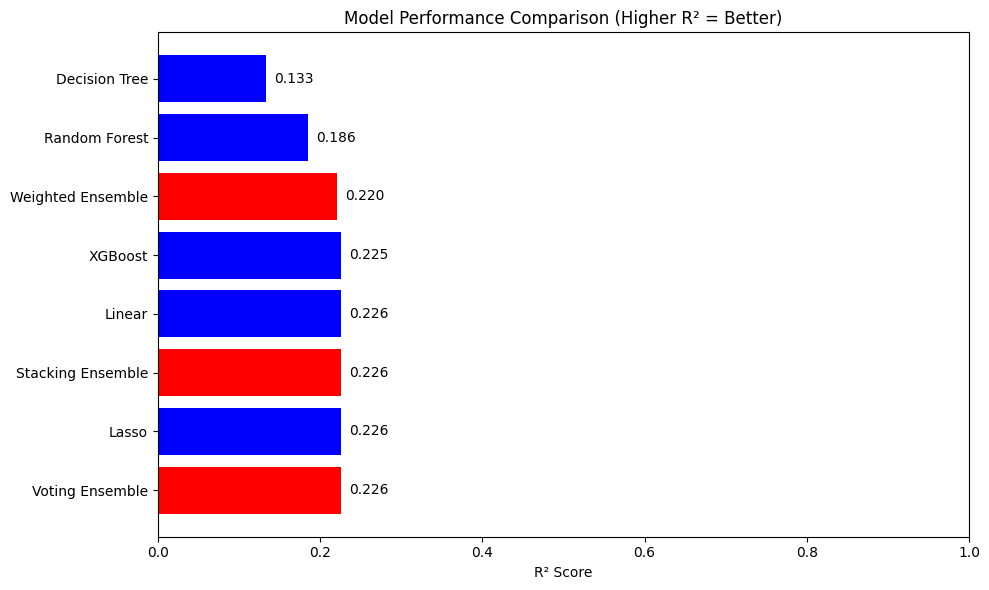

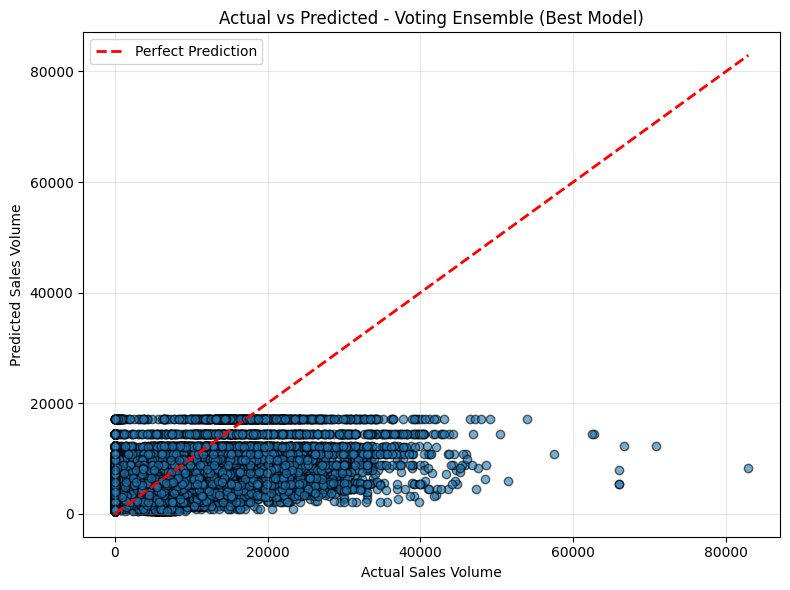

In [22]:
# ==================== VISUALIZATION (Optional) ====================
print("\n" + "=" * 50)
print("VISUALIZATION PREVIEW")
print("=" * 50)

# You can add matplotlib/plotly visualizations here
import matplotlib.pyplot as plt
import plotly.express as px

# 1. R² Comparison Bar Chart
fig1, ax1 = plt.subplots(figsize=(10, 6))
models_list = comparison_df['Model']
r2_scores_list = comparison_df['R²']
colors = ['red' if 'Ensemble' in str(model) else 'blue' for model in models_list]

bars = ax1.barh(models_list, r2_scores_list, color=colors)
ax1.set_xlabel('R² Score')
ax1.set_title('Model Performance Comparison (Higher R² = Better)')
ax1.set_xlim([0, 1])

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Model comparison chart saved as 'model_comparison.png'")

# 2. Actual vs Predicted for best model
best_model_name = comparison_df.iloc[0]['Model']
best_predictions = {
    'Linear': y_pred_lr,
    'Lasso': y_pred_lasso,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'Voting Ensemble': y_pred_voting,
    'Stacking Ensemble': y_pred_stacking,
    'Weighted Ensemble': y_pred_weighted
}

y_pred_best = best_predictions[best_model_name]

fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.scatter(y_test, y_pred_best, alpha=0.6, edgecolors='k')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Sales Volume')
ax2.set_ylabel('Predicted Sales Volume')
ax2.set_title(f'Actual vs Predicted - {best_model_name} (Best Model)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'best_model_predictions_{best_model_name.replace(" ", "_")}.png', 
            dpi=300, bbox_inches='tight')
print(f"✓ Best model ({best_model_name}) predictions saved")



VISUALIZATION PREVIEW

Converting data to lists for plotting...
DEBUG: Number of models: 8
DEBUG: Models found: ['Voting Ensemble', 'Lasso', 'Stacking Ensemble', 'Linear', 'XGBoost', 'Weighted Ensemble', 'Random Forest', 'Decision Tree']

Creating metric comparison charts...
✓ Model comparison chart saved as 'model_comparison_all_metrics.png'

Creating normalized scores visualization...

DEBUG: Normalized scores (with min offset):
  Voting Ensemble      R²: 1.0000, MAE: 0.9794, RMSE: 1.0000
  Lasso                R²: 0.9992, MAE: 1.0000, RMSE: 0.9992
  Stacking Ensemble    R²: 0.9992, MAE: 0.9979, RMSE: 0.9991
  Linear               R²: 0.9986, MAE: 0.9946, RMSE: 0.9986
  XGBoost              R²: 0.9929, MAE: 0.9401, RMSE: 0.9927
  Weighted Ensemble    R²: 0.9403, MAE: 0.7986, RMSE: 0.9386
  Random Forest        R²: 0.5663, MAE: 0.4401, RMSE: 0.5593
  Decision Tree        R²: 0.0100, MAE: 0.0100, RMSE: 0.0100
✓ Normalized scores comparison saved as 'normalized_scores_comparison.png'



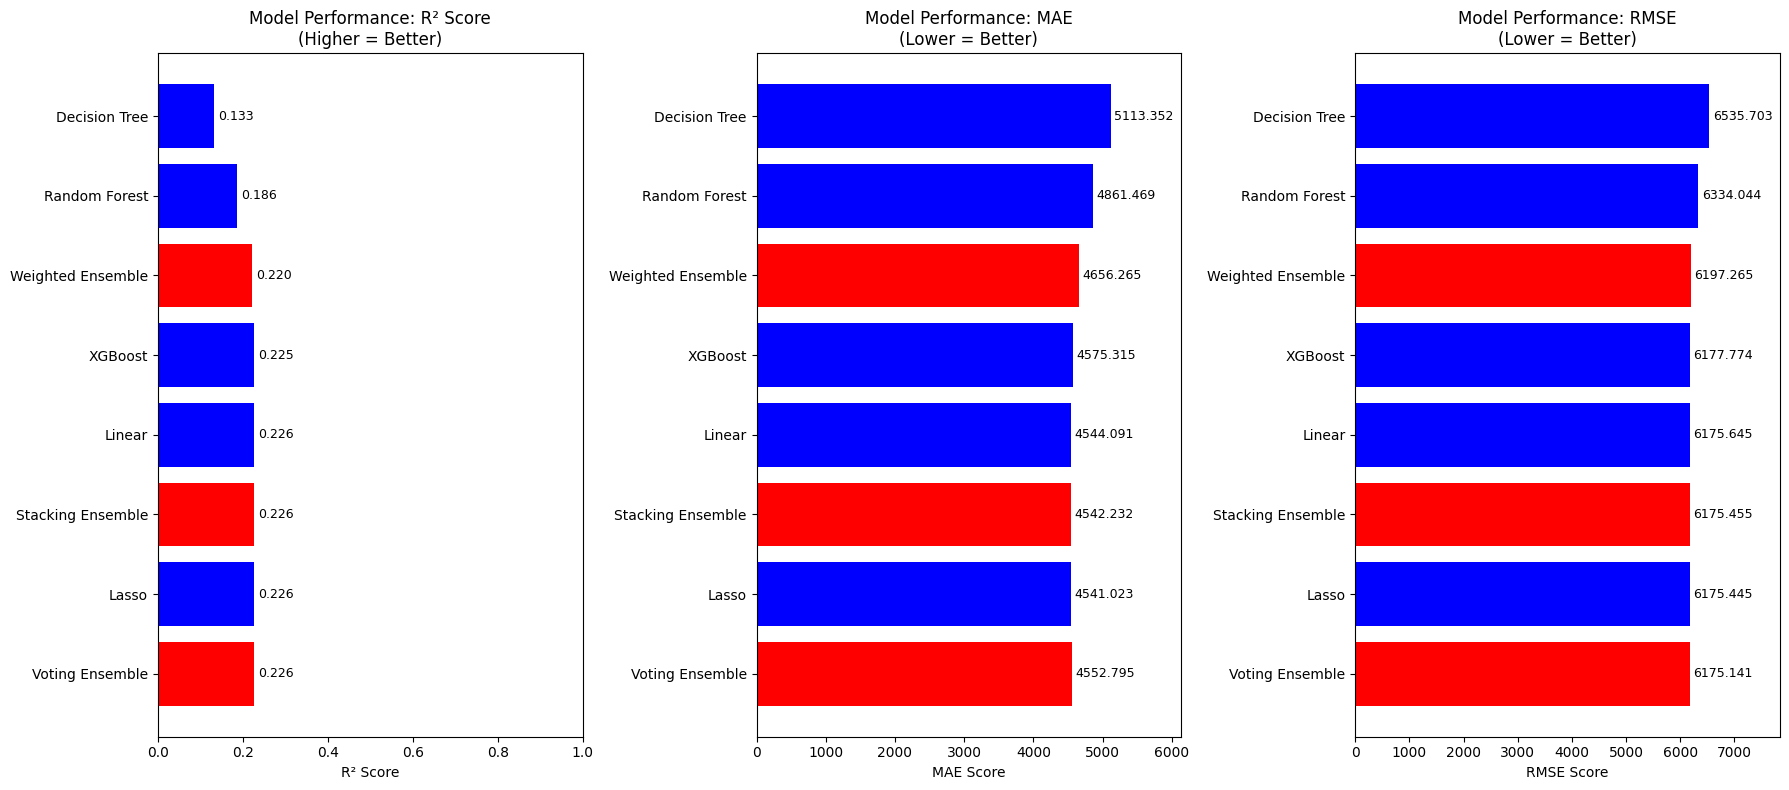

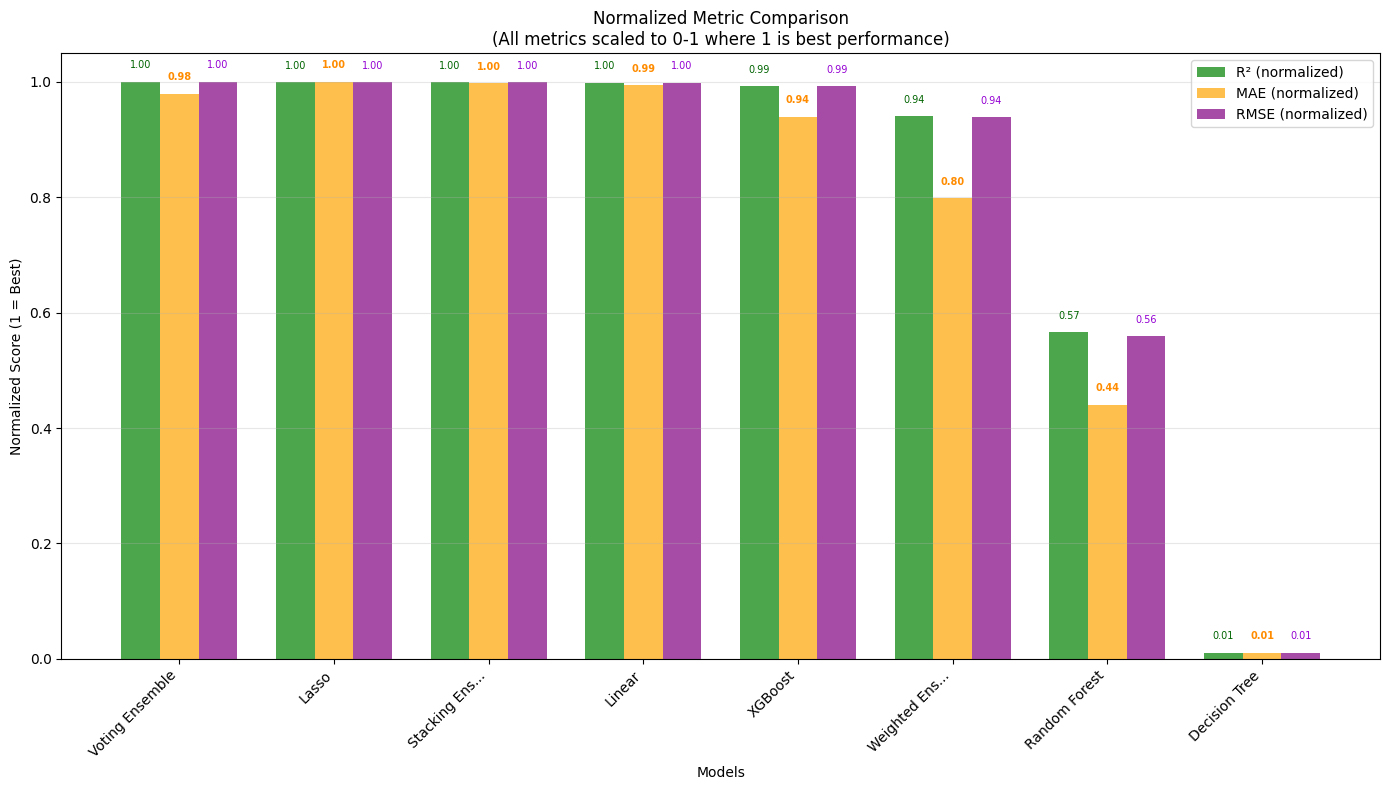

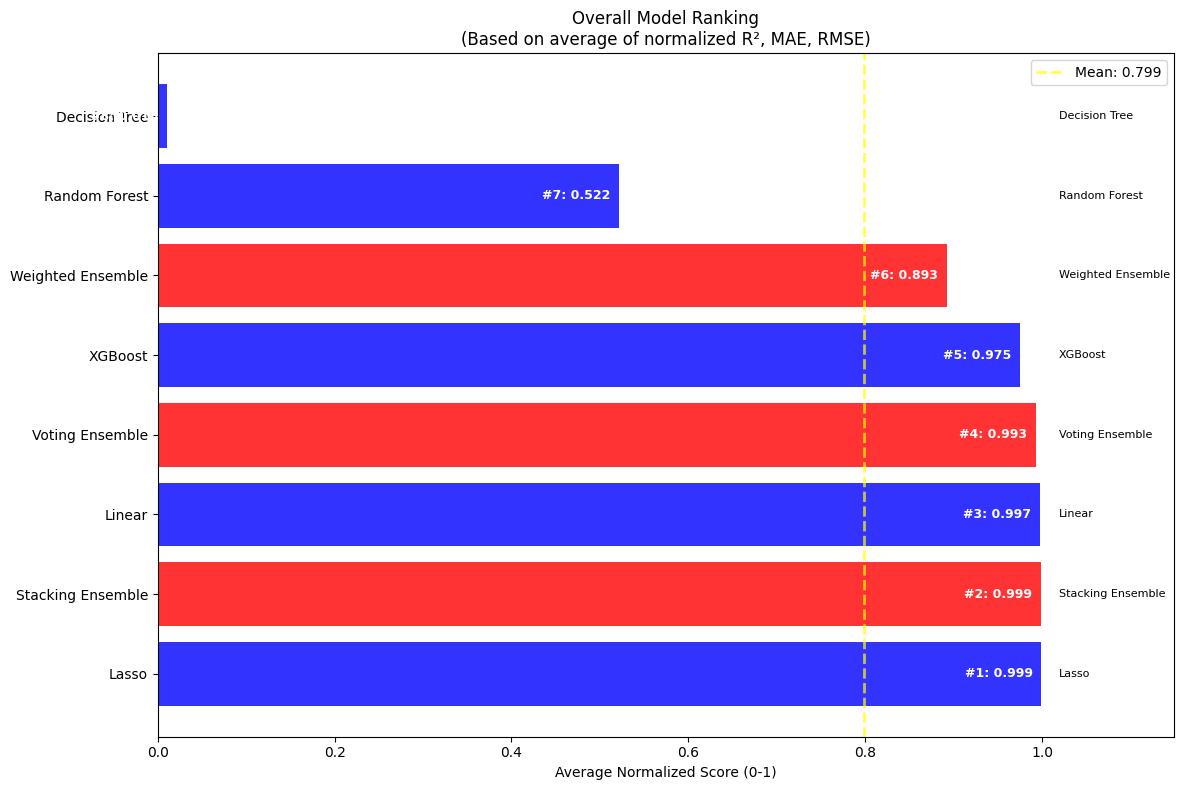

In [27]:
# ==================== VISUALIZATION (Optional) ====================
print("\n" + "=" * 50)
print("VISUALIZATION PREVIEW")
print("=" * 50)

# You can add matplotlib/plotly visualizations here
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

# ==============================================================
# FIXED: Convert to proper Python lists to avoid indexing issues
# ==============================================================
print("\nConverting data to lists for plotting...")

# Convert ALL series to lists to ensure proper indexing
models_list = comparison_df['Model'].tolist()
r2_scores_list = comparison_df['R²'].tolist()
mae_scores_list = comparison_df['MAE'].tolist()
rmse_scores_list = comparison_df['RMSE'].tolist()

print(f"DEBUG: Number of models: {len(models_list)}")
print(f"DEBUG: Models found: {models_list}")

# Color coding: Red for Ensemble models, Blue for others
colors = ['red' if 'Ensemble' in str(model) else 'blue' for model in models_list]

# ==============================================================
# VISUALIZATION 1: Separate metric comparison (3 panels)
# ==============================================================
print("\nCreating metric comparison charts...")

fig1, axes1 = plt.subplots(1, 3, figsize=(18, 8))

# 1. R² Comparison Bar Chart (Higher is better)
ax1 = axes1[0]
bars1 = ax1.barh(models_list, r2_scores_list, color=colors)
ax1.set_xlabel('R² Score')
ax1.set_title('Model Performance: R² Score\n(Higher = Better)')
ax1.set_xlim([0, max(1, max(r2_scores_list) * 1.1)])
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels for R²
for bar in bars1:
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

# 2. MAE Comparison Bar Chart (Lower is better)
ax2 = axes1[1]
bars2 = ax2.barh(models_list, mae_scores_list, color=colors)
ax2.set_xlabel('MAE Score')
ax2.set_title('Model Performance: MAE\n(Lower = Better)')
# Set x-limit to show all values with some padding
mae_max = max(mae_scores_list)
ax2.set_xlim([0, mae_max * 1.2])
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels for MAE
for bar in bars2:
    width = bar.get_width()
    ax2.text(width + (mae_max * 0.01), bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

# 3. RMSE Comparison Bar Chart (Lower is better)
ax3 = axes1[2]
bars3 = ax3.barh(models_list, rmse_scores_list, color=colors)
ax3.set_xlabel('RMSE Score')
ax3.set_title('Model Performance: RMSE\n(Lower = Better)')
# Set x-limit to show all values with some padding
rmse_max = max(rmse_scores_list)
ax3.set_xlim([0, rmse_max * 1.2])
ax3.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels for RMSE
for bar in bars3:
    width = bar.get_width()
    ax3.text(width + (rmse_max * 0.01), bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_all_metrics.png', dpi=300, bbox_inches='tight')
print("✓ Model comparison chart saved as 'model_comparison_all_metrics.png'")

# ==============================================================
# VISUALIZATION 2: Normalized scores comparison - FIXED!
# ==============================================================
print("\nCreating normalized scores visualization...")

# Convert to numpy arrays for easier calculations
r2_scores_array = np.array(r2_scores_list)
mae_scores_array = np.array(mae_scores_list)
rmse_scores_array = np.array(rmse_scores_list)

# FIX: Add a small epsilon to avoid division by zero and perfect zeros
epsilon = 1e-10

# Normalize scores for comparison (0-1 scale where 1 is best)
# For R²: higher is better, so normalize directly
r2_min, r2_max = min(r2_scores_array), max(r2_scores_array)
r2_range = r2_max - r2_min + epsilon
r2_normalized = (r2_scores_array - r2_min) / r2_range

# FIX: For MAE and RMSE: lower is better, so we need special handling
# Instead of simple inversion, we'll use a modified approach
mae_min, mae_max = min(mae_scores_array), max(mae_scores_array)
rmse_min, rmse_max = min(rmse_scores_array), max(rmse_scores_array)

# Method 1: Inverse normalization (preserves relative differences)
mae_range = mae_max - mae_min + epsilon
rmse_range = rmse_max - rmse_min + epsilon

# Normalize MAE and RMSE (0 to 1, where 0 is best, 1 is worst)
mae_normalized_raw = (mae_scores_array - mae_min) / mae_range
rmse_normalized_raw = (rmse_scores_array - rmse_min) / rmse_range

# Invert so 1 is best (like R²)
mae_normalized = 1 - mae_normalized_raw
rmse_normalized = 1 - rmse_normalized_raw

# FIX: Ensure no zero values by adding small offset
r2_normalized = np.maximum(r2_normalized, 0.01)
mae_normalized = np.maximum(mae_normalized, 0.01)
rmse_normalized = np.maximum(rmse_normalized, 0.01)

print(f"\nDEBUG: Normalized scores (with min offset):")
for i, model in enumerate(models_list):
    print(f"  {model[:20]:<20} R²: {r2_normalized[i]:.4f}, MAE: {mae_normalized[i]:.4f}, RMSE: {rmse_normalized[i]:.4f}")

# Create a new figure for normalized scores
fig2, ax2 = plt.subplots(figsize=(14, 8))

x = np.arange(len(models_list))
width = 0.25

# Create bars for each metric
bars_r2 = ax2.bar(x - width, r2_normalized, width, label='R² (normalized)', color='green', alpha=0.7)
bars_mae = ax2.bar(x, mae_normalized, width, label='MAE (normalized)', color='orange', alpha=0.7)
bars_rmse = ax2.bar(x + width, rmse_normalized, width, label='RMSE (normalized)', color='purple', alpha=0.7)

ax2.set_xlabel('Models')
ax2.set_ylabel('Normalized Score (1 = Best)')
ax2.set_title('Normalized Metric Comparison\n(All metrics scaled to 0-1 where 1 is best performance)')
ax2.set_xticks(x)

# Truncate long model names for display
model_labels = []
for model in models_list:
    model_str = str(model)
    if len(model_str) > 15:
        model_labels.append(model_str[:12] + '...')
    else:
        model_labels.append(model_str)

ax2.set_xticklabels(model_labels, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars (show all three metrics in a compact way)
for i, (r2_val, mae_val, rmse_val) in enumerate(zip(r2_normalized, mae_normalized, rmse_normalized)):
    # Show small text labels above each bar group
    ax2.text(i - width, r2_val + 0.02, f'{r2_val:.2f}', 
             ha='center', va='bottom', fontsize=7, color='darkgreen')
    ax2.text(i, mae_val + 0.02, f'{mae_val:.2f}', 
             ha='center', va='bottom', fontsize=7, color='darkorange', fontweight='bold')
    ax2.text(i + width, rmse_val + 0.02, f'{rmse_val:.2f}', 
             ha='center', va='bottom', fontsize=7, color='darkviolet')

plt.tight_layout()
plt.savefig('normalized_scores_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Normalized scores comparison saved as 'normalized_scores_comparison.png'")

# ==============================================================
# VISUALIZATION 3: Overall ranking - FIXED!
# ==============================================================
print("\nCreating overall ranking visualization...")

# Calculate average normalized score
avg_normalized = (r2_normalized + mae_normalized + rmse_normalized) / 3

print(f"\nDEBUG: Average normalized scores:")
for i, model in enumerate(models_list):
    print(f"  {model[:20]:<20} Avg: {avg_normalized[i]:.4f}")

# Create a new figure for ranking
fig3, ax3 = plt.subplots(figsize=(12, 8))

# Sort models by average normalized score (descending)
sorted_indices = np.argsort(avg_normalized)[::-1]
sorted_models = [models_list[i] for i in sorted_indices]
sorted_scores = [avg_normalized[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

print(f"\nDEBUG: Ranking order:")
for rank, idx in enumerate(sorted_indices):
    print(f"  #{rank+1}: {models_list[idx]} (score: {avg_normalized[idx]:.4f})")

# Create horizontal bar chart
y_positions = range(len(sorted_models))
bars_rank = ax3.barh(y_positions, sorted_scores, color=sorted_colors, alpha=0.8)

ax3.set_yticks(y_positions)
# Truncate model names for y-axis labels
y_labels = []
for model in sorted_models:
    model_str = str(model)
    if len(model_str) > 25:
        y_labels.append(model_str[:22] + '...')
    else:
        y_labels.append(model_str)

ax3.set_yticklabels(y_labels)
ax3.set_xlabel('Average Normalized Score (0-1)')
ax3.set_title('Overall Model Ranking\n(Based on average of normalized R², MAE, RMSE)')

# Set x-axis limit to show all bars clearly
ax3.set_xlim([0, max(sorted_scores) * 1.15])

# Add value labels and rank number
for i, bar in enumerate(bars_rank):
    width = bar.get_width()
    # Position text inside bar for better visibility
    text_pos = width - (max(sorted_scores) * 0.01)
    ha = 'right'
    color = 'white'
    
    ax3.text(text_pos, bar.get_y() + bar.get_height()/2, 
             f'#{i+1}: {width:.3f}', ha=ha, va='center', 
             color=color, fontsize=9, fontweight='bold')
    
    # Also add the actual model name at the end of the bar
    model_name = str(sorted_models[i])
    if len(model_name) > 30:
        model_name = model_name[:27] + '...'
    ax3.text(max(sorted_scores) * 1.02, bar.get_y() + bar.get_height()/2,
             model_name, ha='left', va='center', fontsize=8)

# Add vertical line at average
mean_score = np.mean(sorted_scores)
ax3.axvline(x=mean_score, color='yellow', linestyle='--', alpha=0.7, linewidth=2,
           label=f'Mean: {mean_score:.3f}')
ax3.legend()

plt.tight_layout()
plt.savefig('model_overall_ranking.png', dpi=300, bbox_inches='tight')
print("✓ Overall ranking saved as 'model_overall_ranking.png'")

# ==============================================================
# CONSOLE SUMMARY
# ==============================================================
print("\n" + "=" * 75)
print("PERFORMANCE SUMMARY")
print("=" * 75)
print(f"{'Model':<35} {'R²':<8} {'MAE':<10} {'RMSE':<10} {'Avg Norm':<12} {'Rank'}")
print("-" * 90)

# Calculate ranks
ranks = np.argsort(avg_normalized)[::-1]  # Descending order
rank_dict = {}
for rank, idx in enumerate(ranks):
    rank_dict[models_list[idx]] = rank + 1

# Print table
for i, model in enumerate(models_list):
    model_name = str(model)
    if len(model_name) > 32:
        model_name = model_name[:29] + "..."
    
    print(f"{model_name:<35} {r2_scores_list[i]:<8.4f} {mae_scores_list[i]:<10.4f} "
          f"{rmse_scores_list[i]:<10.4f} {avg_normalized[i]:<12.4f} {rank_dict[model]}")

# Show best model for each metric
best_r2_idx = np.argmax(r2_scores_array)
best_mae_idx = np.argmin(mae_scores_array)
best_rmse_idx = np.argmin(rmse_scores_array)

print("\n" + "=" * 75)
print("BEST MODELS FOR EACH METRIC")
print("=" * 75)
print(f"Best R²   ({r2_scores_list[best_r2_idx]:.4f}): {models_list[best_r2_idx]}")
print(f"Best MAE  ({mae_scores_list[best_mae_idx]:.4f}): {models_list[best_mae_idx]}")
print(f"Best RMSE ({rmse_scores_list[best_rmse_idx]:.4f}): {models_list[best_rmse_idx]}")

# Show overall best model
overall_best_idx = np.argmax(avg_normalized)
print(f"\nOverall Best Model ({avg_normalized[overall_best_idx]:.4f} avg norm score):")
print(f"  {models_list[overall_best_idx]}")

# Special note about Decision Tree
print(f"\n" + "=" * 75)
print("NOTE ON NORMALIZATION")
print("=" * 75)
print("Decision Tree has the worst scores for all metrics, so its normalized")
print("values would be 0.0. We've added a minimum offset of 0.01 to ensure")
print("it appears in the visualizations while preserving the ranking.")

print("\n" + "=" * 75)
print("FILES GENERATED")
print("=" * 75)
print("1. model_comparison_all_metrics.png - Side-by-side metric comparison")
print("2. normalized_scores_comparison.png - Normalized metrics visualization")
print("3. model_overall_ranking.png - Overall model ranking")

# Show quick preview if running in interactive environment
try:
    plt.show()
except:
    print("\nNote: Run in interactive environment to display plots directly.")

In [ ]:
# ==================== SAVE MODELS ====================
print("\n" + "=" * 50)
print("MODEL SAVING")
print("=" * 50)

import joblib
import pickle

# Save all models
for name, model in models.items():
    filename = f'model_{name.replace(" ", "_").lower()}.pkl'
    joblib.dump(model, filename)
    print(f"✓ {name} saved as {filename}")

# Save ensembles
joblib.dump(voting_reg, 'model_voting_ensemble.pkl')
joblib.dump(stacking_reg, 'model_stacking_ensemble.pkl')
print("✓ Ensemble models saved")

# Save scaler
joblib.dump(scaler, 'feature_scaler.pkl')
print("✓ Feature scaler saved")

# Save comparison results
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("✓ Comparison results saved as 'model_comparison_results.csv'")

print("\n" + "=" * 50)
print("ALL MODELS TRAINED AND EVALUATED SUCCESSFULLY!")
print("=" * 50)

In [21]:
# Interpretability – Coefficients 
#Linear Regression 
coef_df = pd.DataFrame({ 
"feature": X_final.columns, 
"coefficient": lin_reg.coef_ 
}).sort_values("coefficient", key=abs, ascending=False) 
coef_df.head(20)

,feature,coefficient
96,State_Kano,-6.254968e+15
58,station_name_geo_Kano,5.919634e+15
85,station_name_geo_Oyo 3,-4.074286e+15
91,State_Bauchi,-3.358792e+15
32,station_name_geo_Bauchi,2.588131e+15
34,station_name_geo_Benue,-2.570805e+15
30,station_name_geo_Asaba,-2.252139e+15
89,station_name_geo_Yola,-1.993827e+15
88,station_name_geo_Tegina,-1.516362e+15
93,State_Delta,1.369185e+15


In [22]:
#Lasso (feature selection) 
lasso_df = pd.DataFrame({ 
"feature": X_final.columns, 
"coefficient": lasso.coef_ 
}) 
lasso_selected = lasso_df[lasso_df["coefficient"] != 0].sort_values("coefficient", key=abs, ascending=False) 
lasso_selected.head(20) 

,feature,coefficient
68,station_name_geo_Ojodu,10692.653992
15,station_name_geo_Ado 1,8326.171789
65,station_name_geo_Ogbomosho 1,7279.810503
80,station_name_geo_Ondo Surulere,6047.421182
36,station_name_geo_Efon Alaye,-5851.286926
50,station_name_geo_Ile-Oluji 2,-5584.314706
51,station_name_geo_Ilesha 1,5278.815908
35,station_name_geo_Ede 2,-4987.479341
82,station_name_geo_Owo,4955.914865
69,station_name_geo_Ojoo Barracks,-4938.280577


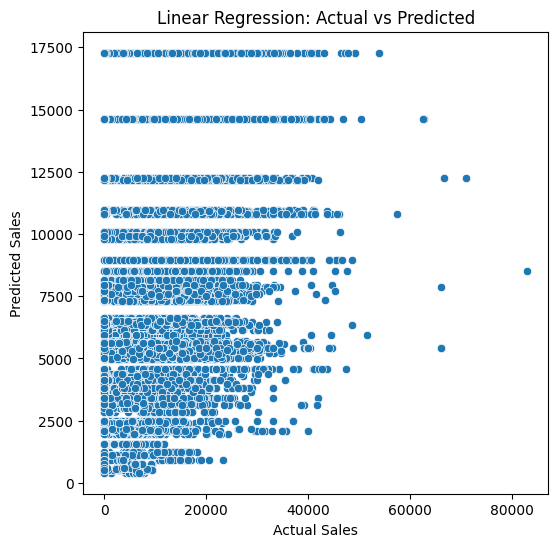

In [23]:
#Basic Diagnostic Plot 
plt.figure(figsize=(6, 6)) 
sns.scatterplot(x=y_test, y=y_pred_lr) 
plt.xlabel("Actual Sales") 
plt.ylabel("Predicted Sales") 
plt.title("Linear Regression: Actual vs Predicted") 
plt.show() 

In [24]:
# Permutation Feature Importance (Model-Agnostic) 
#This tells you how much performance drops when a feature is shuffled. 
from sklearn.inspection import permutation_importance 
 
perm = permutation_importance( 
    lin_reg, 
    X_test, 
    y_test, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1 
) 
 
perm_df = pd.DataFrame({ 
    "feature": X_final.columns, 
    "importance": perm["importances_mean"] 
}).sort_values("importance", ascending=False) 
 
perm_df.head(20) 

,feature,importance
96,State_Kano,2.041247e+22
58,station_name_geo_Kano,1.828249e+22
85,station_name_geo_Oyo 3,8.501811e+21
91,State_Bauchi,5.322408e+21
1,Longitude,4.714896e+21
34,station_name_geo_Benue,3.445699e+21
2,distance_to_nearest_road_m,3.327849e+21
32,station_name_geo_Bauchi,3.160200e+21
30,station_name_geo_Asaba,2.671475e+21
89,station_name_geo_Yola,2.223614e+21


In [25]:
# Create SHAP explainer 
import shap 
explainer = shap.LinearExplainer( 
lin_reg, 
X_train, 
feature_names=X_final.columns 
)

In [26]:
# Compute SHAP values 
shap_values = explainer(X_test) 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


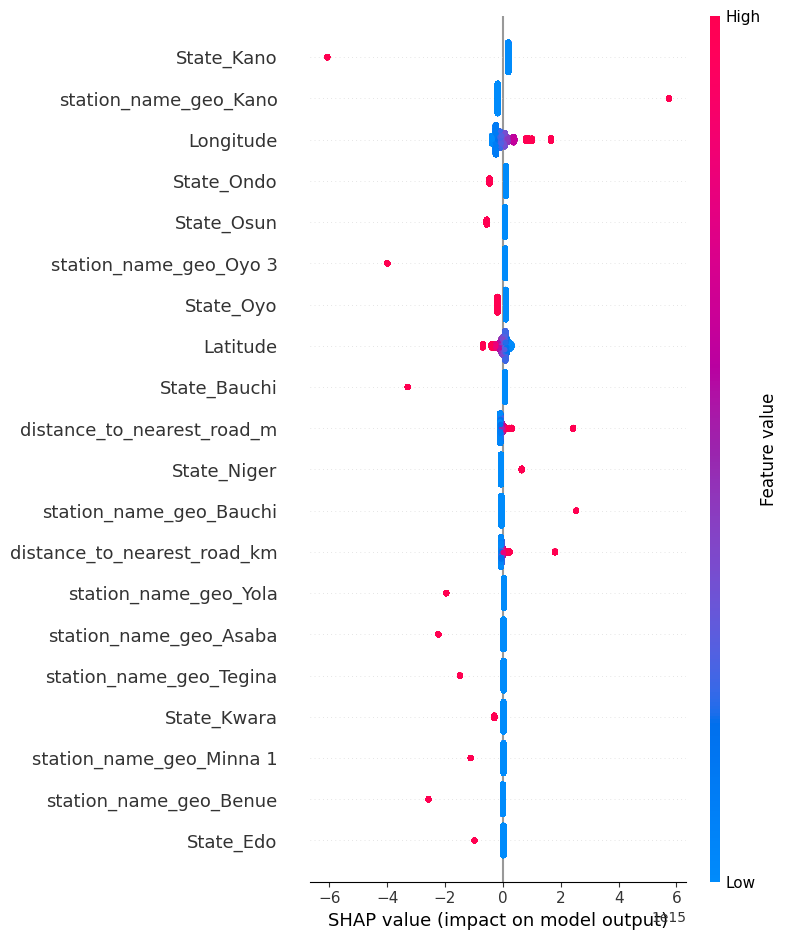

In [27]:
# Global importance (summary plot) 
shap.summary_plot( 
shap_values, 
X_test, 
feature_names=X_final.columns 
)

# nterpretation: 
# ● Top features globally 
# ● Direction (red ↑, blue ↓) 
# ● Spread = variability across stations/dates 

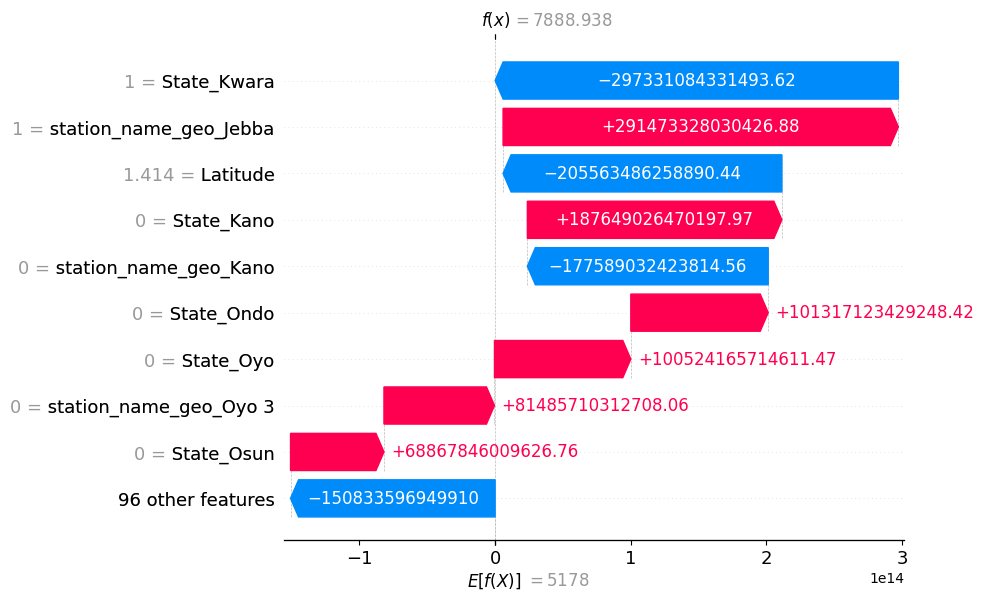

In [28]:
# Local explanation (single station) 
idx = 0  # choose any row 
shap.plots.waterfall(shap_values[idx]) 

# Interpretation: 
# ● Why THIS prediction is high/low 
# ● Perfect for case studies in a thesis 

In [29]:
# Create LIME explainer 
from lime.lime_tabular import LimeTabularExplainer 
 
lime_explainer = LimeTabularExplainer( 
    training_data=X_train.values, 
    feature_names=X_final.columns.tolist(), 
    mode="regression", 
    discretize_continuous=True, 
    random_state=42 
) 

In [30]:
# Prediction function (IMPORTANT) 
def lime_predict_fn(x): 
    return lin_reg.predict(x)

In [31]:
# Explain a single prediction 
idx = 0  # index in X_test 
 
lime_exp = lime_explainer.explain_instance( 
    X_test.iloc[idx].values, 
    lime_predict_fn, 
    num_features=10 
) 

X does not have valid feature names, but LinearRegression was fitted with feature names


In [32]:
# Display explanation 
lime_exp.show_in_notebook() 
 

# Interpretation: 
# ● “Feature X increases prediction by Y” 
# ● Very intuitive for non-technical stakeholders 

In [33]:
# SHAP vs LIME for the Same Point 
print("Actual:", y_test.iloc[idx]) 
print("Predicted:", lin_reg.predict(X_test.iloc[[idx]])[0]) 

Actual: 6700.0
Predicted: 7888.875
